# TAD Calling Benchmark

This notebook contains the code to reproduce Figure 3 and S8-S13.

Required data are:

1. Takei et al, 2021, Nature: 25 Kb dataset from two biological replicates

    data.json: takei_nature_2021, 25Kb, rep1 and rep2

    4DN data portal ID: 4DNFIHF3JCBY (rep1), 4DNFIQXONUUH (rep2)

2. Su et al, 2020, Cell: 50 Kb resolution whole chromosome 21

    Download the first four tsv from https://zenodo.org/records/3928890
    
    Uncomment `proc_su_cell_2020(args.datadir)` and run in terminal

    This outputs ../data/su_cell_2020/chromosome21.csv.

3. ChIP-seq data of mouse embryonic stem cells

    data.json: chipseq_mesc

4. FISHnet single cell boundaries

    Called using the FISHnet software

    Result deposited in ../data/fishnet_takei_nature_2021/fishnet_all.tsv

5. TSS annotation from UCSC genome browser

    Downloaded directly using ArcFISH

In [1]:
import os, json
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import out_dire
from utils.data import DataTree

import arcfish as af

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
dtree = DataTree("../data")

In [4]:
loader = af.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, nm_ratio={c: 1000 for c in "XYZ"})

## Domain boundaries from different noise level

Run `figures/scripts/11_err_rep.py` as described in the file. 

This creates two tsv files:

- loop_err_rep_all.tsv
- domain_err_rep_all.tsv

In [6]:
c1, c2 = sns.palettes.color_palette("dark")[:2]
palette = {"Insulation": c1, "ArcFISH": c2}

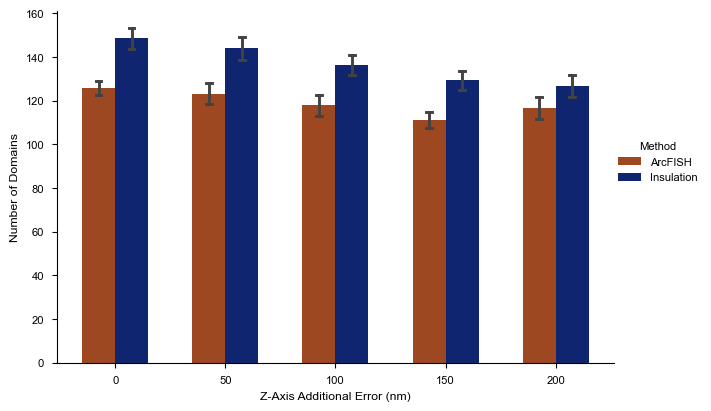

In [7]:
rep_call_all = pd.read_csv(os.path.join(out_dire, "domain_err_rep_all.tsv"), sep="\t")
domain_count = rep_call_all.groupby(["method", "err", "rep"])["c1"].count().reset_index()
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(domain_count, x="err", y="c1", hue="method", width=.6, errorbar="sd",
            palette=palette, capsize=.1, native_scale=True, ax=ax)
ax.grid(False)
ax.set(xlabel="Z-Axis Additional Error (nm)", ylabel="Number of Domains")
ax.legend(title="Method")
fig.savefig(os.path.join(out_dire, "domain_err_number.pdf"), bbox_inches="tight")

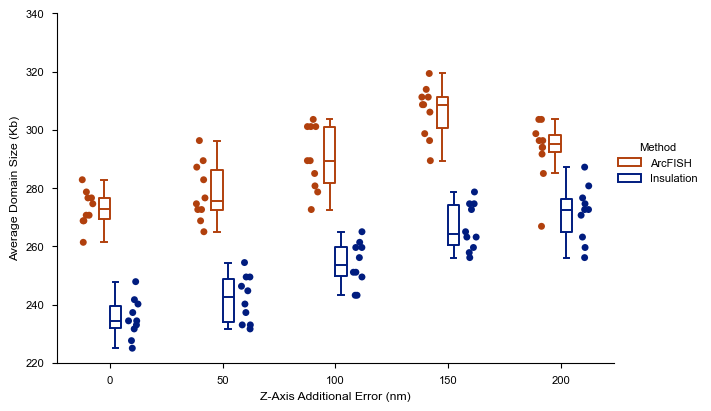

In [8]:
rep_call_all["size"] = rep_call_all["e2"] - rep_call_all["s1"]
size_df = rep_call_all.groupby(["method", "err", "rep"])["size"].mean().reset_index()
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(size_df, x="err", y="size", hue="method", palette=palette, 
            native_scale=True, width=.2, fill=False, showfliers=False, ax=ax)
sns.stripplot(size_df, x="err", y="size", hue="method", palette=palette, 
              native_scale=True, dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Method")
ax.set(xlabel="Z-Axis Additional Error (nm)", ylabel="Average Domain Size (Kb)")
ax.set(yticks=ax.get_yticks(), yticklabels=[f"{int(x/1000)}" for x in ax.get_yticks()])
ax.grid(False)
fig.savefig(os.path.join(out_dire, "domain_err_size.pdf"), bbox_inches="tight")

In [9]:
from utils.utils import domain_output_to_boundary
rep0 = rep_call_all[rep_call_all["rep"]==0]
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]

shared_frac = []
for method, sub_df in rep0.groupby("method"):
    sub_df0 = sub_df[sub_df["err"]==0]
    boundaries0 = domain_output_to_boundary(sub_df0[cols])
    for err in [50, 100, 150, 200]:
        sub_df1 = sub_df[sub_df["err"]==err]
        boundaries1 = domain_output_to_boundary(sub_df1[cols])
        
        shared = af.tl.signal_overlap(boundaries1, boundaries0, 0)
        shared = np.sum(shared["overlapped"]==1)
        shared_frac.append([method, err, shared, len(boundaries0) - shared, 
                            len(boundaries1) - shared])
c = ["method", "err", "Shared", "Raw Specific", "Noise Specific"]
shared_frac = pd.DataFrame(shared_frac, columns=c)

shared_frac[c[2:]] /= shared_frac[c[2:]].sum(axis=1).values[:,None]
shared_frac

,method,err,Shared,Raw Specific,Noise Specific
0,ArcFISH,50,0.743802,0.115702,0.140496
1,ArcFISH,100,0.708333,0.158333,0.133333
2,ArcFISH,150,0.650407,0.195122,0.154472
3,ArcFISH,200,0.641667,0.225000,0.133333
4,Insulation,50,0.448276,0.275862,0.275862
5,Insulation,100,0.363636,0.352273,0.284091
6,Insulation,150,0.390805,0.333333,0.275862
7,Insulation,200,0.331395,0.401163,0.267442


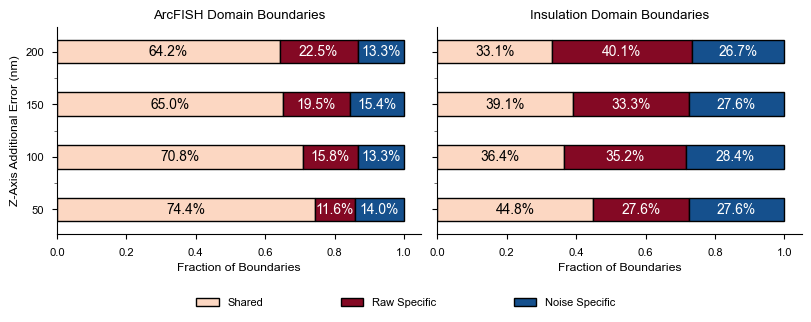

In [10]:
fig = plt.figure(figsize=(8, 3.2))
figs = fig.subfigures(2, 1, height_ratios=[3, .5])
axes = figs[0].subplots(1, 2, sharey=True)
color = [plt.colormaps["RdBu"](t) for t in [100, 10, 240]]
for ax, (method, df) in zip(axes, shared_frac.groupby("method")):
    df.iloc[:,2:].plot(kind="barh", stacked=True, edgecolor="k", 
                       color=color, width=.45, linewidth=1, ax=ax)
    ax.get_legend().set_visible(False)
    ax.set(yticks=ax.get_yticks(), yticklabels=df["err"].values)
    ax.set(xlabel="Fraction of Boundaries", ylabel="Z-Axis Additional Error (nm)")
    ax.set(title=f"{method} Domain Boundaries")
    ax.grid(False)
    
    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                f"{bar.get_width()*100:.1f}%", ha="center", va="center",
                color="k" if i < 4 else "w")
handles, labels = axes[1].get_legend_handles_labels()
figs[1].legend(handles, labels, loc="center", ncol=3, columnspacing=7)
fig.savefig(os.path.join(out_dire, "domain_err_rep_shared_frac.pdf"), bbox_inches="tight")

In [11]:
tss = af.tl.ABCaller(0, "mm10").tss

In [12]:
d1df = af.tl.all_possible_bins(loader)
tss_count = []
for chr_id, df in d1df.groupby("c1", sort=False):
    sub_tss = tss[tss["Chrom"]==chr_id]
    for idx, row in df.iterrows():
        a = sub_tss["Chrom_End"] - row["s1"] < -1
        b = row["e1"] - sub_tss["Chrom_Start"] < -1
        tss_count.append([row["c1"], row["s1"], row["e1"], np.sum(~(a|b))])
tss_count = pd.DataFrame(tss_count, columns=["c1", "s1", "e1", "tss"])
tss_count

,c1,s1,e1,tss
0,chr1,135600000,135625000,0
1,chr1,135625000,135650000,0
2,chr1,135650000,135675000,0
3,chr1,135675000,135700000,0
4,chr1,135700000,135725000,1
...,...,...,...,...
1195,chrX,76900457,76925457,0
1196,chrX,76925457,76950457,0
1197,chrX,76950457,76975457,0
1198,chrX,76975457,77000457,0


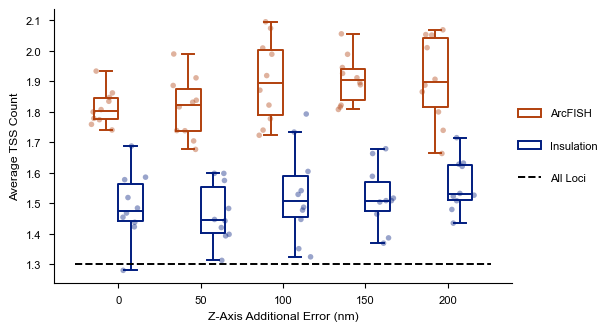

In [13]:
tss_by_rep = []
for idx, df in rep_call_all.groupby(["method", "err", "rep"]):
    boundaries = domain_output_to_boundary(df)
    df = pd.merge(boundaries, tss_count, on=["c1", "s1", "e1"], how="left")
    tss_by_rep.append([*idx, df["tss"].mean()])
tss_by_rep = pd.DataFrame(tss_by_rep, columns=["method", "err", "rep", "tss"])
fig, ax = plt.subplots(figsize=(6, 3.2))
sns.boxplot(tss_by_rep, x="err", y="tss", hue="method", palette=palette, 
            showfliers=False, native_scale=True, width=.6, fill=False, ax=ax)
ax.hlines(tss_count.tss.mean(), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
          color="k", linestyle="--", label="All Loci")
sns.stripplot(tss_by_rep, x="err", y="tss", hue="method", palette=palette,
              dodge=True, jitter=.3, alpha=.4, s=4, native_scale=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3], labelspacing=2, 
          loc="center", bbox_to_anchor=(1.1, .5))
ax.set(xlabel="Z-Axis Additional Error (nm)", ylabel="Average TSS Count")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "domain_err_rep_tss.pdf"), bbox_inches="tight")

In [15]:
stats.wilcoxon(
    tss_by_rep[tss_by_rep["method"]=="Insulation"].tss.values,
    tss_by_rep[tss_by_rep["method"]=="ArcFISH"].tss.values,
    alternative="greater"
)

WilcoxonResult(statistic=0.0, pvalue=1.0)

## Domains from the original data

In [16]:
res_sf1_path = os.path.join(out_dire, "tad_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    tad = af.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    af.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "tad_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    tad = af.tl.TADCaller(tree=False, method="pval")
    af.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

In [23]:
from utils.utils import domain_output_to_boundary
print("Insulation boundaries:", len(domain_output_to_boundary(res_sf1)), "TADs: ", len(res_sf1))
print("ArcFISH boundaries:", len(domain_output_to_boundary(res_sf2)), "TADs: ", len(res_sf2))

Insulation boundaries: 135 TADs:  155
ArcFISH boundaries: 105 TADs:  125


In [18]:
adata = loader.create_adata("chr3")

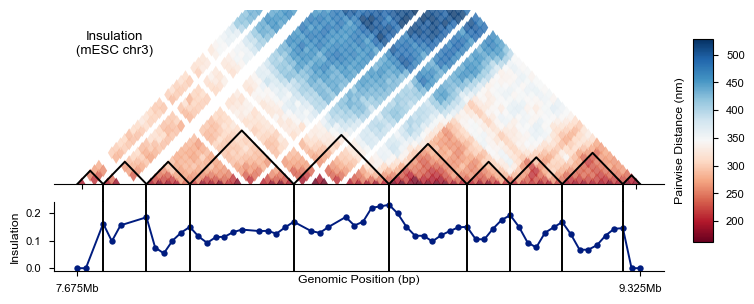

In [19]:
caller1 = af.tl.TADCaller(tree=False, method="insulation", distance=2, prominence=.04)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = af.pl.triangle_domain_boundary(adata, caller1, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation\n(mESC chr3)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "domain_insu_chr3.pdf"), bbox_inches="tight")

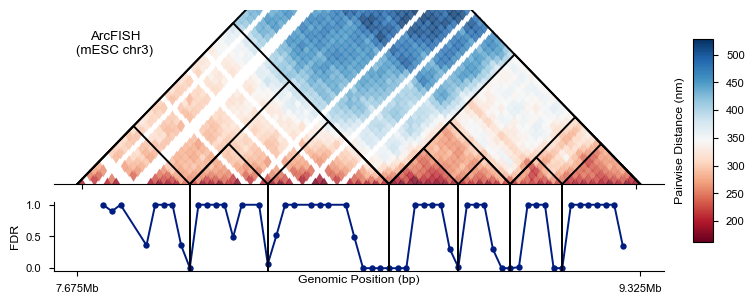

In [20]:
caller2 = af.tl.TADCaller(tree=True, method="pval", fdr_cutoff=.1)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = af.pl.triangle_domain_boundary(adata, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"ArcFISH\n(mESC chr3)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "domain_snapfish2_chr3.pdf"), bbox_inches="tight")

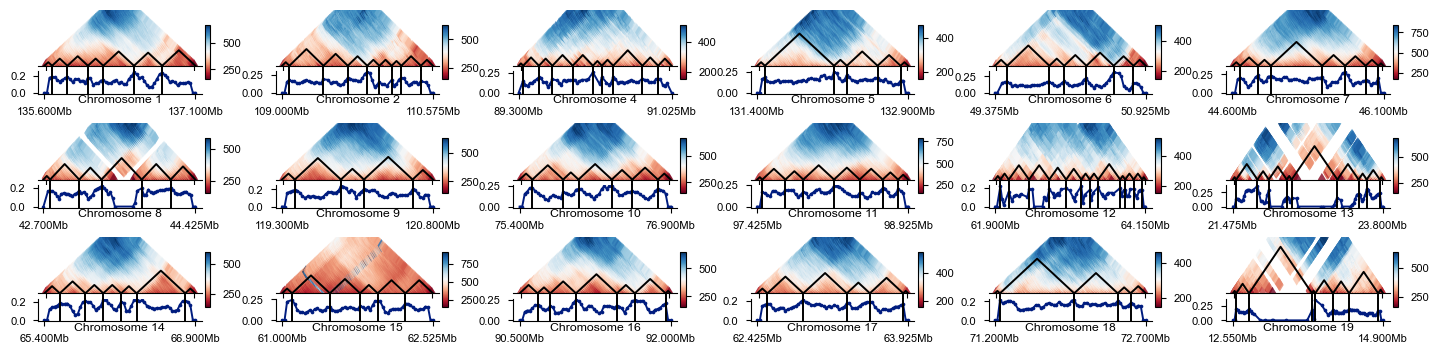

In [21]:
fig = plt.figure(figsize=(14, 3.2))
figs = fig.subfigures(3, 6, hspace=.2, wspace=.11)
chr_ids = [i for i in range(1, 20) if i != 3]
for chr_id, f in zip(chr_ids, figs.flat):
    f.get_size_inches = lambda : fig.get_size_inches()/6
    adata = loader.create_adata(f"chr{chr_id}")
    ax, cbar, cax = af.pl.triangle_domain_boundary(adata, caller1, fig=f, cut_hi=1.2e6)
    cax.set(ylabel=None, xlabel=f"Chromosome {chr_id}")
fig.savefig(os.path.join(out_dire, "domain_insulation_all.pdf"), bbox_inches="tight")

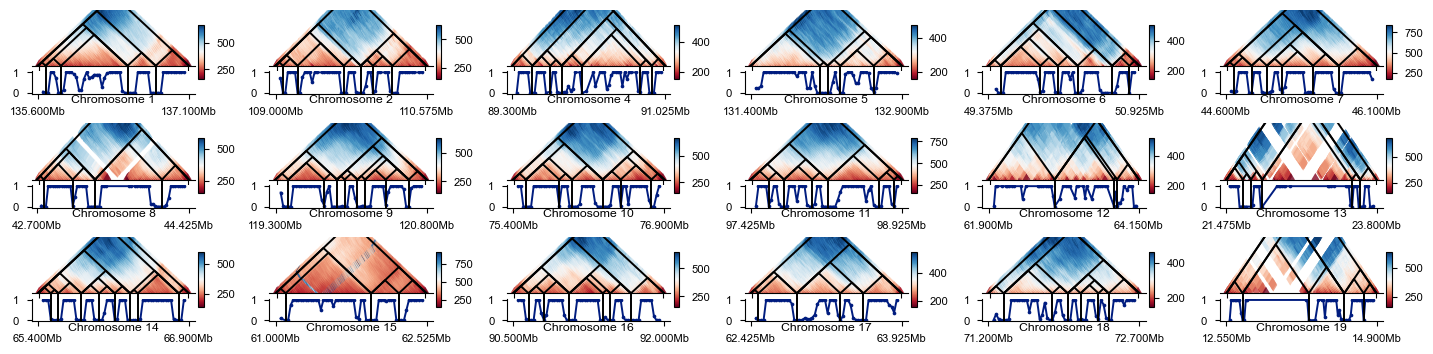

In [22]:
fig = plt.figure(figsize=(14, 3.2))
figs = fig.subfigures(3, 6, hspace=.2, wspace=.11)
chr_ids = [i for i in range(1, 20) if i != 3]
for chr_id, f in zip(chr_ids, figs.flat):
    f.get_size_inches = lambda : fig.get_size_inches()/6
    adata = loader.create_adata(f"chr{chr_id}")
    ax, cbar, cax = af.pl.triangle_domain_boundary(adata, caller2, fig=f, cut_hi=1.2e6)
    cax.set(ylabel=None, xlabel=f"Chromosome {chr_id}")
fig.savefig(os.path.join(out_dire, "domain_arcfish_all.pdf"), bbox_inches="tight")

In [24]:
from utils.lines import boundary_mean_enrichment
window = 250e3
markers = ["CTCF", "POLR2A", "H3K4me3", "H3K36me3", "H3K9ac", "H3K9me3"]
b1 = domain_output_to_boundary(res_sf1)
b2 = domain_output_to_boundary(res_sf2)

dfs = []
for i, marker in enumerate(markers):
    wig_path = dtree["chipseq_mesc", marker, "bigWig"]
    l1 = boundary_mean_enrichment(wig_path, b1, loader, window)
    l1["method"] = "Insulation"
    l2 = boundary_mean_enrichment(wig_path, b2, loader, window)
    l2["method"] = "ArcFISH"
    dfs.append(pd.concat([l1, l2]))

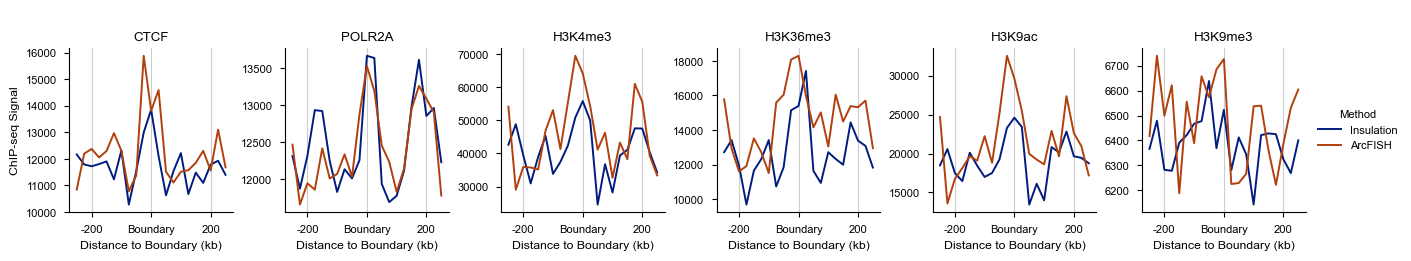

In [25]:
fig, axes = plt.subplots(1, 7, figsize=(14, 2.5), width_ratios=[1]*6+[.3])
for i, (df, marker) in enumerate(zip(dfs, markers)):
    axes[i].set_box_aspect(1)
    sns.lineplot(df, x="1d", y="val", hue="method", palette=palette, ax=axes[i])
    axes[i].set(xlabel="Distance to Boundary (kb)", 
                ylabel="ChIP-seq Signal" if i==0 else "")
    axes[i].set_title(marker)
    axes[i].set(xticks=[-200e3, 0, 200e3], xticklabels=["-200", "Boundary", "200"])
    # axes[i].set(yticks=[])
    axes[i].get_legend().set_visible(False)
    axes[i].grid(False)
    axes[i].grid(True, axis='x')
handles, labels = axes[0].get_legend_handles_labels()
axes[-1].legend(handles, labels, title="Method", loc="center")
axes[-1].axis("off")
fig.savefig(os.path.join(out_dire, "domain_boundary_line.pdf"), bbox_inches="tight")

In [28]:
from utils.utils import domain_chipseq_df
up_rglt = ["CTCF", "POLR2A", "H3K4me3", "H3K36me3", "H3K9ac"]
down_rglt = ["H3K9me3"]
markers = up_rglt + down_rglt
enrich_df = domain_chipseq_df(dtree, loader, res_sf1, res_sf2, markers, "chipseq_mesc")

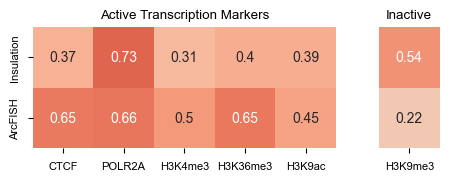

In [30]:
dfr = pd.merge(enrich_df[enrich_df["Method"]!="Average"], 
               enrich_df[enrich_df["Method"]=="Average"], on="marker")
dfr["fold"] = np.log2(dfr["frac_x"]/dfr["frac_y"])
dfr["type"] = "Raw"
dfr.rename(columns={"Method_x": "Method"}, inplace=True)
dfr["Method"] = dfr["Method"].map({"SnapFISH": "Insulation", "ArcFISH": "ArcFISH"})
plt_df = dfr.pivot(index="Method", columns="marker", values="fold")
plt_df = plt_df.loc[["Insulation", "ArcFISH"]]

fig, axes = plt.subplots(1, 2, figsize=(4.5, 1.7), width_ratios=[6, 1])
sns.heatmap(plt_df[up_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", cbar=False, ax=axes[0])
labels = axes[0].get_xticklabels()
axes[0].set_xticklabels(labels, ha="center")
axes[0].set(title="Active Transcription Markers", xlabel="", ylabel="")
axes[0].grid(False)
sns.heatmap(plt_df[down_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", yticklabels=False, ax=axes[1], cbar=False)
axes[1].set(title="Inactive", xlabel="", ylabel="")
axes[1].grid(False)
fig.savefig(os.path.join(out_dire, "domain_mesc_enrich.pdf"), bbox_inches="tight")

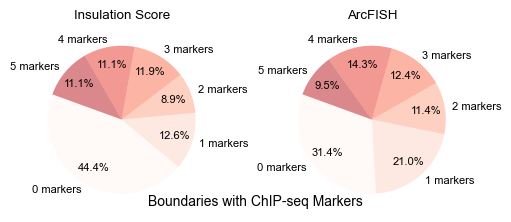

In [31]:
from utils.utils import domain_add_chipseq_col

colors = [plt.get_cmap("Reds")(int(i*250/6)) for i in range(6)]
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

res = res_sf1.copy()
for marker in up_rglt:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[0].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75,
    wedgeprops={"alpha": .5}, colors=colors,
)
axes[0].set_title("Insulation Score")

res = res_sf2.copy()
for marker in up_rglt:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[1].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75, 
    wedgeprops={"alpha": .5}, colors=colors
)
axes[1].set_title("ArcFISH")

fig.suptitle("Boundaries with ChIP-seq Markers", y=0.2, fontsize=10)
fig.savefig(os.path.join(out_dire, "domain_chipseq_pie.pdf"), bbox_inches="tight")

## FISHnet

In [32]:
caller2 = af.tl.TADCaller(tree=False, method="pval", fdr_cutoff=.1)
sf2_boundaries = pd.concat([
    caller2.call_tads(loader.create_adata(f"chr{i}"))
    for i in range(1, 20)
])

In [28]:
fishnet_all = pd.read_csv(os.path.join(out_dire, "fishnet_all.tsv"), sep="\t")
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
fishnet_count = (
    fishnet_all.groupby(cols, sort=False)["bin1"]
    .count().to_frame("count").reset_index()
)
num_df = fishnet_all[["c1", "c2", "num_trace"]].drop_duplicates()
fishnet_count = pd.merge(fishnet_count, num_df, how="left", on=["c1", "c2"])
fishnet_count["freq"] = fishnet_count["count"] / fishnet_count["num_trace"]

In [29]:
fishnet_all

,bin1,bin2,Trace_ID,c1,c2,s1,e1,s2,e2,num_trace
0,0,18,rep1_0_1_1_1,chr1,chr1,135600000,135625000,136050000,136075000,594
1,18,34,rep1_0_1_1_1,chr1,chr1,136050000,136075000,136450000,136475000,594
2,34,39,rep1_0_1_1_1,chr1,chr1,136450000,136475000,136575000,136600000,594
3,39,47,rep1_0_1_1_1,chr1,chr1,136575000,136600000,136775000,136800000,594
4,47,59,rep1_0_1_1_1,chr1,chr1,136775000,136800000,137075000,137100000,594
...,...,...,...,...,...,...,...,...,...,...
38726,34,49,rep2_0_17_19_0,chr19,chr19,14250000,14275000,14625000,14650000,498
38727,49,59,rep2_0_17_19_0,chr19,chr19,14625000,14650000,14875000,14900000,498
38728,0,13,rep2_0_17_19_1,chr19,chr19,12550000,12575000,12875000,12900000,498
38729,13,29,rep2_0_17_19_1,chr19,chr19,12875000,12900000,14125000,14150000,498


In [36]:
boundary_count = (
    fishnet_all
    .groupby("Trace_ID", sort=False)
    .apply(lambda x: pd.concat([
        x[["c1", "s1", "e1"]], x[["c2", "s2", "e2"]].rename({
            "c2": "c1", "s2": "s1", "e2": "e1"
        }, axis=1)]).drop_duplicates(), include_groups=False)
    .reset_index()
    .groupby(["c1", "s1", "e1"], sort=False, group_keys=False)["Trace_ID"]
    .count()
    .reset_index()
)
sf2_fish_df = pd.merge(boundary_count, sf2_boundaries, left_on=["c1", "s1", "e1"], 
                       right_on=["c1", "Chrom_Start", "Chrom_End"], how="left")

In [37]:
sf2_fish_df

,c1,s1,e1,Trace_ID,Chrom_Start,Chrom_End,stat_x,stat_y,stat_z,pval_x,pval_y,pval_z,stat,stat_prox,pval,fdr,fdr_peak,raw_peak,peak
0,chr1,135600000,135625000,444,135600000,135625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,chr1,136050000,136075000,41,136050000,136075000,0.961490,0.979689,1.021580,6.483652e-02,2.139970e-01,7.947198e-01,9.444116e-01,0.002545,2.590976e-01,6.909270e-01,False,False,False
2,chr1,136450000,136475000,28,136450000,136475000,0.863971,0.857022,0.850023,5.663892e-10,7.607377e-11,7.661121e-12,2.141624e+10,0.078155,1.486300e-11,1.189040e-10,True,False,False
3,chr1,136575000,136600000,30,136575000,136600000,0.999730,0.966700,1.030854,4.959732e-01,7.920891e-02,8.978765e-01,-4.812113e-01,-0.003143,6.427633e-01,1.000000e+00,False,False,False
4,chr1,136775000,136800000,28,136775000,136800000,0.892521,0.924075,0.799381,1.587210e-06,6.079390e-04,5.048647e-20,7.949887e+15,0.079475,0.000000e+00,0.000000e+00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,chr19,12875000,12900000,14,12875000,12900000,1.144976,1.061650,1.393874,9.939433e-01,8.657413e-01,1.000000e+00,-2.425417e+08,-0.099734,1.000000e+00,1.000000e+00,False,False,False
1091,chr19,12650000,12675000,1,12650000,12675000,1.090462,1.061413,1.017008,9.990611e-01,9.836603e-01,7.270991e-01,-1.103803e+02,-0.024908,9.971163e-01,1.000000e+00,False,False,False
1092,chr19,14675000,14700000,15,14675000,14700000,0.981459,1.028390,0.918110,2.364747e-01,8.600488e-01,5.137993e-04,2.628056e+02,0.017310,1.211193e-03,7.569958e-03,True,True,True
1093,chr19,14575000,14600000,7,14575000,14600000,0.993706,1.061080,1.026868,4.088366e-01,9.852962e-01,8.359645e-01,-6.417606e+00,-0.012545,9.507962e-01,1.000000e+00,False,False,False


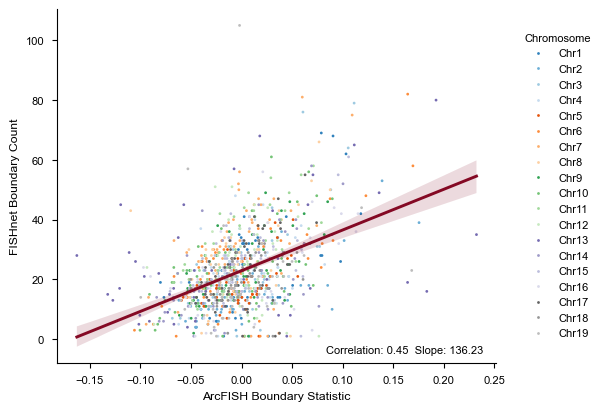

In [38]:
plt_df = sf2_fish_df.dropna(subset=["stat"])
fig, axes = plt.subplots(1, 2, figsize=(6, 4), width_ratios=[5, 1])
sns.scatterplot(plt_df, x="stat_prox", y="Trace_ID", hue="c1", 
                s=4, linewidth=0, palette="tab20c", ax=axes[0])
sns.regplot(plt_df, x="stat_prox", y="Trace_ID", scatter=False, 
            color=plt.colormaps["RdBu"](10), ax=axes[0])
axes[0].get_legend().set_visible(False)
axes[0].grid(False)
r, p = stats.pearsonr(plt_df["stat_prox"], plt_df["Trace_ID"])
s = stats.linregress(plt_df["stat_prox"], plt_df["Trace_ID"]).slope
axes[0].text(
    0.97, 0.02,
    f"Correlation: {r:.2f}  Slope: {s:.2f}",
    transform=axes[0].transAxes,
    fontsize=8,
    verticalalignment="bottom",
    horizontalalignment="right"
)
axes[0].set(xlabel="ArcFISH Boundary Statistic", ylabel="FISHnet Boundary Count")

handles, labels = axes[0].get_legend_handles_labels()
labels = [l.title() for l in labels]
axes[1].legend(handles, labels, title="Chromosome", title_fontsize=8,
               ncol=1, loc="center", columnspacing=.4)
axes[1].axis("off")
fig.savefig(os.path.join(out_dire, "domain_fishnet_sf2_scatter.pdf"), bbox_inches="tight")

In [33]:
combined = pd.merge(fishnet_count, res_sf2[cols + ["level"]], on=cols, how="left")
combined

,c1,s1,e1,c2,s2,e2,count,num_trace,freq,level
0,chr1,135600000,135625000,chr1,136050000,136075000,31,594,0.052189,NaN
1,chr1,136050000,136075000,chr1,136450000,136475000,1,594,0.001684,NaN
2,chr1,136450000,136475000,chr1,136575000,136600000,2,594,0.003367,NaN
3,chr1,136575000,136600000,chr1,136775000,136800000,4,594,0.006734,NaN
4,chr1,136775000,136800000,chr1,137075000,137100000,27,594,0.045455,NaN
...,...,...,...,...,...,...,...,...,...,...
11667,chr19,14400000,14425000,chr19,14700000,14725000,1,498,0.002008,NaN
11668,chr19,14700000,14725000,chr19,14850000,14875000,1,498,0.002008,NaN
11669,chr19,14400000,14425000,chr19,14650000,14675000,1,498,0.002008,NaN
11670,chr19,12775000,12800000,chr19,14400000,14425000,1,498,0.002008,NaN


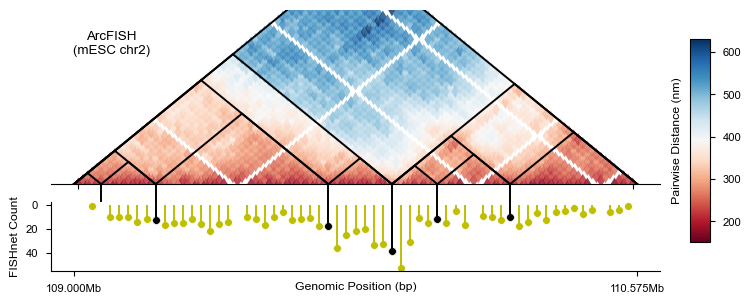

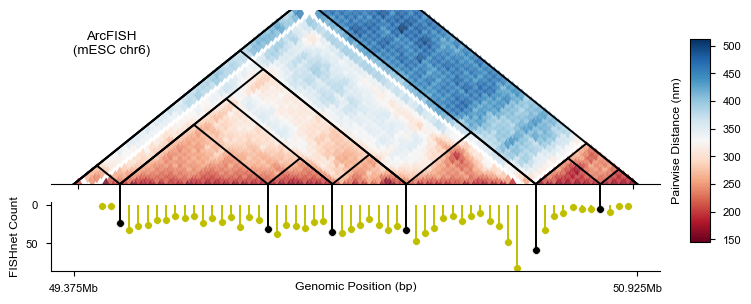

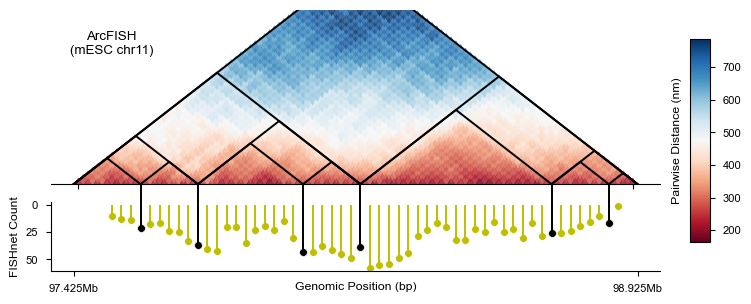

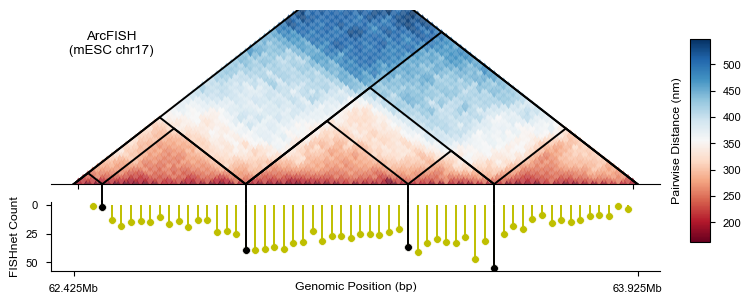

In [39]:
from utils.maps import triangle_boundary_count
caller2 = af.tl.TADCaller(tree=True, method="pval", fdr_cutoff=.1)

for chr_id in ["chr2", "chr6", "chr11", "chr17"]:
    adata = loader.create_adata(chr_id)
    fig = plt.figure(figsize=(7, 2.7))
    ax = triangle_boundary_count(sf2_fish_df, adata, caller2, fig)
    ax.set_title(f"ArcFISH\n(mESC {chr_id})", y=0.7, x=0.1)
    fig.savefig(os.path.join(out_dire, f"domain_fishnet_{chr_id}.pdf"), bbox_inches="tight")

## IMR90 Chromosome 21

In [40]:
import anndata as ad
loader = af.pp.FOF_CT_Loader(f"../data/su_cell_2020/chromosome21.csv")
p21 = os.path.join(out_dire, "chromosome21.h5ad")
if not os.path.exists(p21):
    adata = loader.create_adata("chr21")
    af.tl.median_pdist(adata, inplace=True)
    af.pp.filter_normalize(adata)
    adata.write_h5ad(p21, compression="gzip")
else:
    adata = ad.read_h5ad(p21)

In [41]:
caller_21_insu = af.tl.TADCaller(tree=False, method="insulation",
                                 prominence=0.025, distance=5, window=3e5)
res_insu = caller_21_insu.call_tads(adata)
caller_21_pval = af.tl.TADCaller(tree=False, method="pval", window=3e5)
res_pval = caller_21_pval.call_tads(adata)

In [42]:
res_insu.peak.sum(), res_pval.peak.sum()

(53, 49)

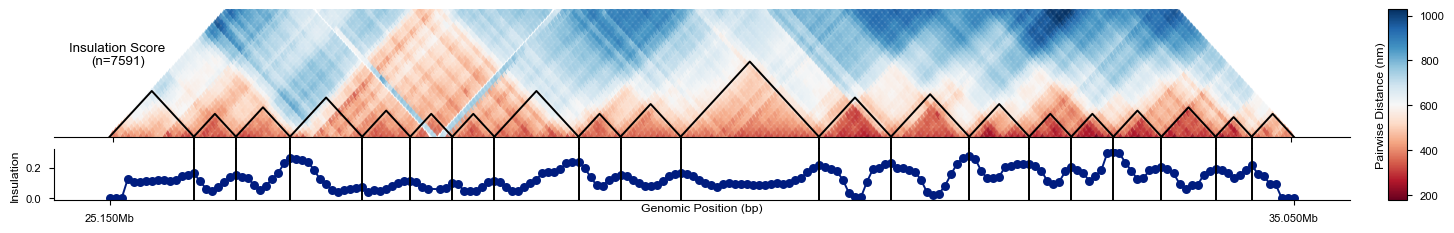

In [43]:
fig = plt.figure(figsize=(14, 2))
sub_adata = adata[:,adata.var["Chrom_Start"] >= 25.15e6]
sub_adata = sub_adata[:,sub_adata.var["Chrom_End"] <= 25.15e6 + 9.95e6]
ax, cbar, cax = af.pl.triangle_domain_boundary(sub_adata, caller_21_insu, fig=fig, cut_hi=2e6)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation Score \n(n=7591)", y=0.5, x=0.05)
fig.savefig(os.path.join(out_dire, "domain_triangle_tad_insulation_21.pdf"), bbox_inches="tight")

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/arcfish/utils/eval.py:186: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]


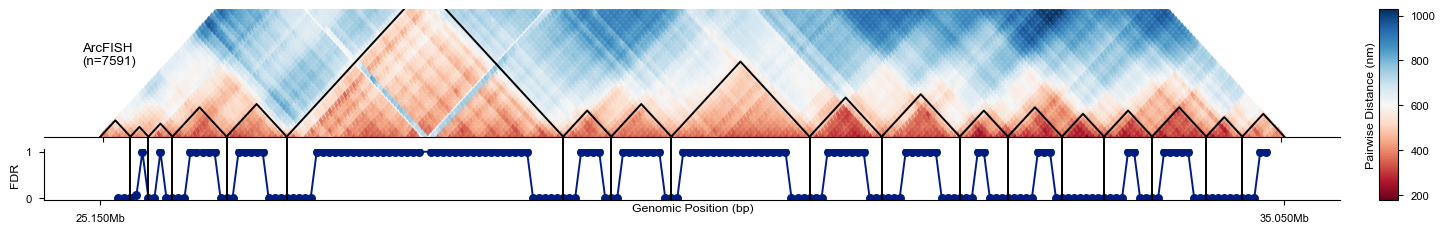

In [44]:
fig = plt.figure(figsize=(14, 2))
sub_adata = adata[:,adata.var["Chrom_Start"] >= 25.15e6]
sub_adata = sub_adata[:,sub_adata.var["Chrom_End"] <= 25.15e6 + 9.95e6]
ax, cbar, cax = af.pl.triangle_domain_boundary(sub_adata, caller_21_pval, fig=fig, cut_hi=2e6)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"ArcFISH \n(n=7591)", y=0.5, x=0.05)
fig.savefig(os.path.join(out_dire, "domain_triangle_tad_pval_21.pdf"), bbox_inches="tight")

/Users/redfishhh/Documents/research/MultiplexedFISH/SnapFISH2/snapfish2/utils/eval.py:186: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]


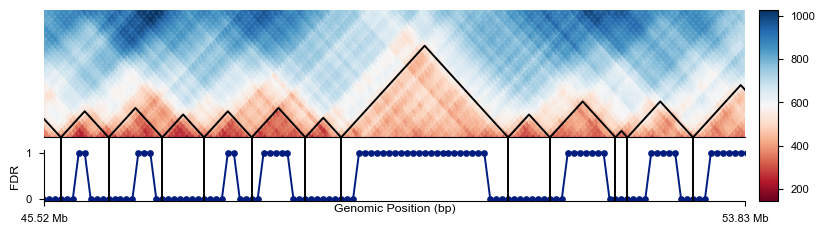

In [ ]:
fig = plt.figure(figsize=(7.8, 2))
sub_adata = adata[:,adata.var["Chrom_Start"] >= 31.15e6]
sub_adata = sub_adata[:,sub_adata.var["Chrom_End"] <= 39.1e6]
ax, cbar, cax = af.pl.triangle_domain_boundary(sub_adata, caller_21_pval, fig=fig, cut_hi=2e6)
plot_range = (32.15e6, 38.1e6)
X = np.array([sub_adata.var.Chrom_Start.min(), sub_adata.var.Chrom_End.max()])
X = np.vstack([np.ones(2), X]).T
beta = np.linalg.inv(X.T@X)@X.T@ax.get_xticks()
new_xlim = np.vstack([np.ones(2), plot_range]).T@beta

ax.set(xlim=new_xlim)
cax.set(xlim=new_xlim, xticks=new_xlim, 
        xticklabels=[f"{x/1e6:.2f} Mb" for x in new_xlim])
for i, l in enumerate(cax.lines[1:]):
    if ax.get_xlim()[0] > l.get_xdata()[0] or ax.get_xlim()[1] < l.get_xdata()[-1]:
        l.set_visible(False)
        ax.lines[i+6].set_visible(False)
fig.savefig(os.path.join(out_dire, "domain_tad_pval_21_zoom.pdf"), bbox_inches="tight")

In [45]:
from utils.utils import domain_chipseq_df

markers = dtree["chipseq_imr90"].keys()
enrich_21 = domain_chipseq_df(
    dtree, loader, caller_21_insu.to_bedpe(res_insu), 
    caller_21_pval.to_bedpe(res_pval), markers, "chipseq_imr90"
)

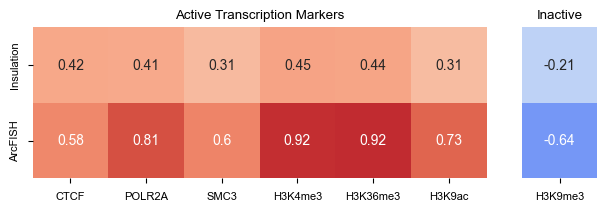

In [46]:
up_rglt = ["CTCF", "POLR2A", "SMC3", "H3K4me3", "H3K36me3", "H3K9ac"]
down_rglt = ["H3K9me3"]
dfr = pd.merge(enrich_21[enrich_21["Method"]!="Average"], 
               enrich_21[enrich_21["Method"]=="Average"], on="marker")
dfr["fold"] = np.log2(dfr["frac_x"]/dfr["frac_y"])
dfr["type"] = "Raw"
dfr.rename(columns={"Method_x": "Method"}, inplace=True)
dfr["Method"] = dfr["Method"].map({"SnapFISH": "Insulation", "ArcFISH": "ArcFISH"})
plt_df = dfr.pivot(index="Method", columns="marker", values="fold")
plt_df = plt_df.loc[["Insulation", "ArcFISH"]]

fig, axes = plt.subplots(1, 2, figsize=(6, 2), width_ratios=[6, 1])
sns.heatmap(plt_df[up_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", cbar=False, ax=axes[0])
labels = axes[0].get_xticklabels()
axes[0].set_xticklabels(labels, ha="center")
axes[0].set(title="Active Transcription Markers", xlabel="", ylabel="")
axes[0].grid(False)
sns.heatmap(plt_df[down_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", yticklabels=False, ax=axes[1], cbar=False)
axes[1].set(title="Inactive", xlabel="", ylabel="")
axes[1].grid(False)
fig.savefig(os.path.join(out_dire, "domain_21_enrich.pdf"), bbox_inches="tight")

Run `figures/scripts/21_tad_rep.py` as described in the file. 

This creates the following tsv file:

- tad_replicate_21_all.csv

In [47]:
rep_path = os.path.join(out_dire, "tad_replicate_21_all.csv")
reps = pd.read_csv(rep_path)

In [48]:
reps_wide = reps[reps.replicate >= 0].pivot_table(
    index=["c1", "Chrom_Start", "Chrom_End"],
    columns=["num_cells", "replicate"], values="fdr", sort=False
)
wide_idx = reps_wide.index.to_frame().reset_index(drop=True)
full = pd.merge(wide_idx, reps[reps.replicate < 0], on=wide_idx.columns.tolist())
corr_df = reps_wide.apply(
    lambda x: stats.pearsonr(x, full["fdr"])[0], axis=0 
).to_frame("corr").reset_index()

full_peak = reps[reps.replicate == -1]
full_peak = full_peak[full_peak.peak].iloc[:,1:3].values

def apply_prc(df):
    tp = np.sum(af.tl.overlap(
        df[df["peak"]].iloc[:,1:3].values, full_peak, offset=0
    ))
    tp = full_peak.shape[0] if tp > full_peak.shape[0] else tp
    # recall, precision
    return tp/full_peak.shape[0], tp/np.sum(df["peak"])
prc_21 = reps[reps.replicate >= 0].groupby(
    ["num_cells", "replicate"], sort=True
).apply(
    lambda df: apply_prc(df), include_groups=False
)
prc_21 = pd.DataFrame(
    np.stack(prc_21.values), columns=["recall", "precision"], index=prc_21.index
).reset_index()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

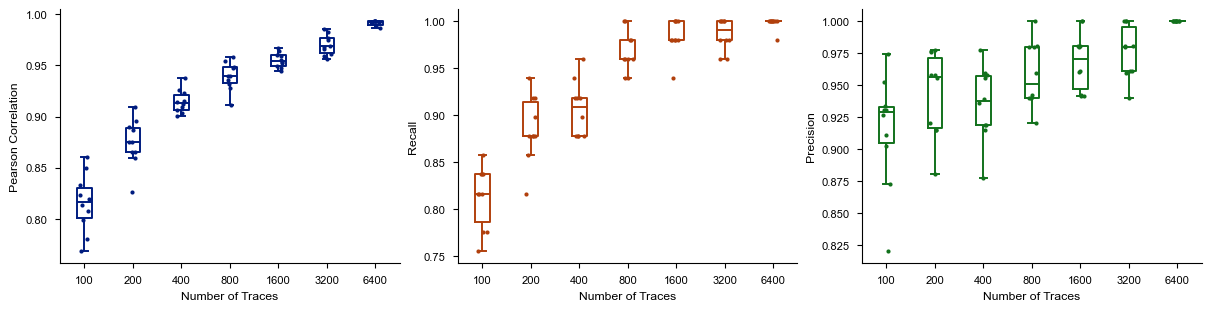

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))


sns.stripplot(corr_df, x="num_cells", y="corr", linewidth=0, s=3, 
              color=sns.color_palette("dark")[0], ax=axes[0])
sns.boxplot(corr_df, x="num_cells", y="corr", width=0.3, fill=False,
            color=sns.color_palette("dark")[0], showfliers=False, ax=axes[0])
axes[0].set(xlabel="Number of Traces", ylabel="Pearson Correlation")
axes[0].grid(False)
sns.stripplot(prc_21, x="num_cells", y="recall", linewidth=0, s=3, 
              color=sns.color_palette("dark")[1], ax=axes[1])
sns.boxplot(prc_21, x="num_cells", y="recall", width=0.3, fill=False,
            color=sns.color_palette("dark")[1], showfliers=False, ax=axes[1])
axes[1].set(xlabel="Number of Traces", ylabel="Recall")
axes[1].grid(False)
sns.stripplot(prc_21, x="num_cells", y="precision", linewidth=0, s=3, 
              color=sns.color_palette("dark")[2], ax=axes[2])
sns.boxplot(prc_21, x="num_cells", y="precision", width=0.3, fill=False,
            color=sns.color_palette("dark")[2], showfliers=False, ax=axes[2])
axes[2].set(xlabel="Number of Traces", ylabel="Precision")
axes[2].grid(False)
fig.savefig(os.path.join(out_dire, "domain_replicate_21.pdf"), bbox_inches="tight")

In [45]:
d1df = adata.var.reset_index(drop=True)
d1df["c1"] = adata.uns["Chrom"]
d1df = d1df.rename(
    {"Chrom_Start": "s1", "Chrom_End": "e1"}, axis=1
)[["c1", "s1", "e1"]]
d1df

,c1,s1,e1
0,chr21,10400001,10450001
1,chr21,10500001,10550001
2,chr21,10600001,10650001
3,chr21,13250001,13300001
4,chr21,14000001,14050001
...,...,...,...
646,chr21,46450001,46500001
647,chr21,46500001,46550001
648,chr21,46550001,46600001
649,chr21,46600001,46650001


In [46]:
from utils.utils import _domain_chipseq_row
up_rglt = ["CTCF", "POLR2A", "SMC3", "H3K4me3", "H3K36me3", "H3K9ac"]
down_rglt = ["H3K9me3"]
markers = up_rglt + down_rglt
d1df = adata.var.reset_index(drop=True)
d1df["c1"] = adata.uns["Chrom"]
d1df = d1df.rename(
    {"Chrom_Start": "s1", "Chrom_End": "e1"}, axis=1
)[["c1", "s1", "e1"]]
avg_rows = []
for marker in markers:
    avg_rows.append(_domain_chipseq_row(dtree, marker, d1df, "chipseq_imr90"))
avg_rows = pd.DataFrame(avg_rows)

rows = []
rep0 = reps[reps.replicate == 0].rename({"Chrom_Start": "s1", "Chrom_End": "e1"}, axis=1)
for n, df in rep0.groupby("num_cells"):
    print(n, np.sum(df.peak))
    for marker in markers:
        row = _domain_chipseq_row(dtree, marker, df[df.peak], dire="chipseq_imr90")
        row["num_cells"] = n
        rows.append(row)
rows = pd.DataFrame(rows)
enrich_df = pd.merge(rows, avg_rows, on=["marker"], how="left")
enrich_df["fold"] = np.log2(enrich_df["frac_x"]/enrich_df["frac_y"])
plt_df = enrich_df.pivot(index="num_cells", columns="marker", values="fold")
plt_df

100 43
200 47
400 47
800 50
1600 52
3200 50
6400 49


marker,CTCF,H3K36me3,H3K4me3,H3K9ac,H3K9me3,POLR2A,SMC3
num_cells,,,,,,,
100,0.723852,0.975391,0.828326,0.612127,-0.521821,1.078947,0.616468
200,0.642833,0.984570,0.622000,0.413413,-0.313111,0.687588,0.488144
400,0.642833,0.984570,0.774003,0.676448,-0.650146,0.868160,0.810072
800,0.506260,0.959433,0.886369,0.646074,-0.739413,0.861355,0.568802
1600,0.712711,0.964250,0.698541,0.405066,-0.400068,0.722310,0.564686
3200,0.599370,0.895303,0.822239,0.646074,-0.595023,0.691430,0.621269
6400,0.582712,0.924449,0.915516,0.731804,-0.636266,0.808039,0.597948


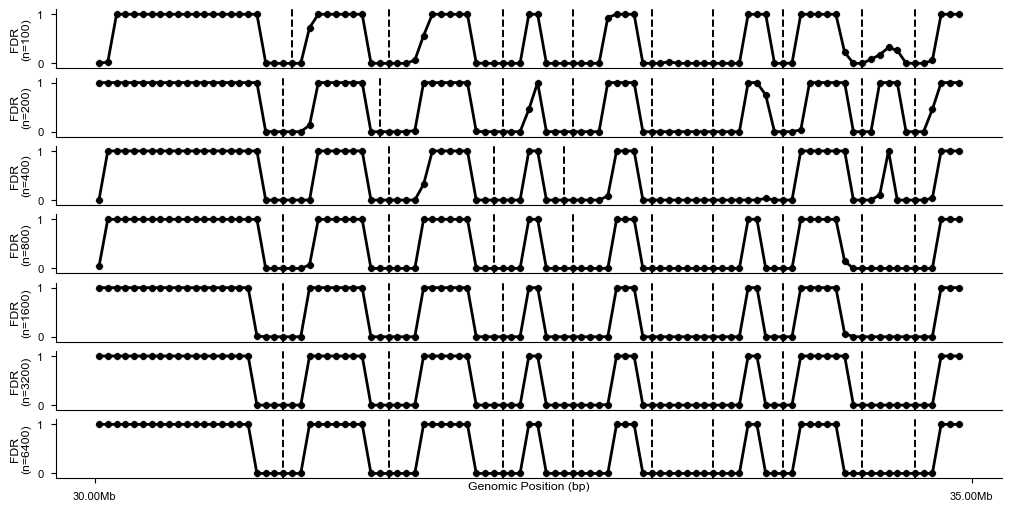

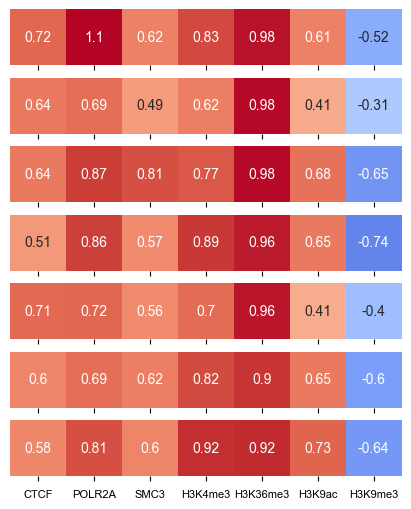

In [138]:
fig1, axes1 = plt.subplots(7, figsize=(10, 5))
fig2, axes2 = plt.subplots(7, figsize=(4, 5))
s1d, e1d = 30e6, 35e6
for i, (n, df) in enumerate(rep0.groupby("num_cells")):
    df = df[(df["s1"]>=s1d)&(df["e1"]<=e1d)].copy()
    df["mid"] = (df["s1"] + df["e1"])/2
    sns.lineplot(df, x="mid", y="fdr", color="k", linewidth=2, ax=axes1[i])
    sns.scatterplot(df, x="mid", y="fdr", color="k", ax=axes1[i])
    axes1[i].grid(False)
    axes1[i].set(ylim=(-0.1, 1.1), ylabel=f"FDR\n(n={n})")
    for x in df[df.peak].mid:
        axes1[i].axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
    sns.heatmap(plt_df.loc[[n]][up_rglt+down_rglt], vmin=-1, vmax=1, annot=True, square=True,
                cmap="coolwarm", yticklabels=False, ax=axes2[i], cbar=False)
    axes2[i].set(xlabel="", ylabel="")
    axes2[i].grid(False)
    if i != 6:
        axes1[i].set(xticks=[], xticklabels=[], xlabel="")
        axes2[i].set(yticks=[], xticklabels=[])
    else:
        axes1[i].set(
            xlabel="Genomic Position (bp)",
            xticks=[s1d, e1d],
            xticklabels=[f"{s1d/1e6:.2f}Mb", f"{e1d/1e6:.2f}Mb"]
        )
        axes1[i].xaxis.set_label_coords(0.5, -.05)
fig1.savefig(os.path.join(out_dire, "domain_21_enrich_by_num1.pdf"), bbox_inches="tight")
fig2.savefig(os.path.join(out_dire, "domain_21_enrich_by_num2.pdf"), bbox_inches="tight")